# IKEA Furniture: Comparing different regression models in order to predict the sales price of new items
### by Niklas Sayer

Table of contents:
- [0. Motivation and preprocessing](#0.-Motivation-and-preprocessing)
- [1. Multilinear regression analysis (Quantitative Variables only)](#1.-Multilinear-regession-analysis:-Quantitative-variables-only)
    - [1.1 Examine multicolinearity](#1.1-Compute-VIFs:-Examine-multicolinearity)
    - [1.2 Other potential problems](#1.2-Taking-a-closer-look-at-potential-problems:-High-leverage-points,-outliers,-heteroscedacity)
    - [1.3 Tackling heteroscedacity](#1.3-Tackling-heteroscedacity:-Transforming-the-response-variable-Y)
    - [1.4 Removing high-leverage points](#1.4-Removing-high-leverage-points)
- [2. Multilinear regression analysis (Adding Qualitative Variables)](#2.-Add-more-(qualitative)-predictors-to-the-model)
    - [2.1 Subset selection](#2.1-Subset-selection:-Perform-Forward-stepwise-selection)
        - [2.1.1 Using $AIC, BIC, R_{adj}^2$](#2.1.1-Estimating-the-test-error:-Using-$AIC,-BIC,-R_{adj}^2$)
        - [2.1.2 Validation model selection](#2.1.2-Estimating-the-test-error:-Validation-Model-Selection)
    - [2.2 Creating an optimized model](#2.2-Creating-an-optimized-model)
        - [2.2.1 Revisiting VIFs](#2.2.1-Revisiting-VIFs-for-our-new-model)
        - [2.2.2 Removing high-leverage points](#2.2.2-Removing-high-leverage-points-from-the-data)
        - [2.2.3 Closer Examination of unusual datapoints](#2.2.3-Further-examination-of-unusual-data-points)
    - [2.3 Interaction terms](#2.3-Adding-interaction-terms)
- [3. Removing the linear assumption: GAM](#3.-Use-of-a-General-Additive-Model-(GAM))
- [4. Conclusions & Outlook](#4.-Conclusions-&-Outlook)

## 0. Motivation and preprocessing

Motivation:  
In this project we try to predict the sales price of IKEA items with different regression methods. It's an interesting project because there should be a strong correlation on the size of a furniture piece and its price. However, there might be some other factors like the category of an item that influence the final sales price. Whatever the nature of the underlying correlation shell be, we try to get a better understanding of the very competitive market of medium-priced furniture. While this exact topic is most interesting from an academic point of view, the used techniques can be applied to other datasets, where they can extract much more economically valuable information.

First, we will do the the imports of all the packages we will need in the course of this project. We then read in the data from the supplied dataset. The data has already been preprocessed by the supplier, therefore our preprocessing is limited to the removal of NaN values.

In [1]:
# import libraries
import statsmodels.api as sm
#import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import seaborn as sns


from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix

from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import bs, dmatrix


from operator import itemgetter
from itertools import combinations

In [2]:
dataset = pd.read_csv('../project/IKEA_SA_Furniture_Web_Scrapings_sss.csv',na_values='?',sep=',',index_col=0) # Import data from csv
dataset = dataset.dropna() # Drop NaNs
dataset = dataset.reset_index()

## 1. Multilinear regession analysis: Quantitative variables only

First, we will only take a look at the correlation that we think is the strongest: Between the size of an item (displayed by the height, width and depth) and its price.

In [3]:
# Try multilinear regression predicting price by using depth, height and width (all quantitative variables) of an object
X = sm.add_constant(dataset[['depth','height','width']])
y = dataset.price
model = sm.OLS(y,X)
estimate = model.fit()
print(estimate.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     1561.
Date:                Tue, 14 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:32:20   Log-Likelihood:                -15299.
No. Observations:                1899   AIC:                         3.061e+04
Df Residuals:                    1895   BIC:                         3.063e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1363.5222     50.212    -27.155      0.0

In [4]:
# Calculate correlation matrix of all quantitative values
dataset[['price','depth','height','width']].corr()

,price,depth,height,width
price,1.000000,0.624527,0.272564,0.769460
depth,0.624527,1.000000,-0.079860,0.428208
height,0.272564,-0.079860,1.000000,0.318152
width,0.769460,0.428208,0.318152,1.000000


Comments
- For all the predictors $\beta_0, \beta_1, \beta_2, \beta_3$ the p-value is 0 which indicates we should reject the null hypothesis that any of those are in reality equal to 0. 
- The F-statistic is also much larger then 1 so we should strongly reject the hypothesis $H_0: \beta_0 = \beta_1 = \beta_2 = \beta_3 = 0$
- There might be a collinearity problem with the variables, as bigger objects tend to be bigger in all dimensions rather then just one. We take a closer look at this in the next step by computing the variance inflation factors.

### 1.1 Compute VIFs: Examine multicolinearity

In [5]:
VIFs = [(predictor, variance_inflation_factor(X.values,_)) \
        for _,predictor in enumerate(list(X))] # list(X) returns column names of df

print('Variance Inflation Factors')
for tup in VIFs:
    print('{:20}'.format(tup[0]), '{:.3f}'.format(tup[1]))

Variance Inflation Factors
const                8.207
depth                1.308
height               1.188
width                1.446


As all variance inflation factors are small (close to 1), they don't indicate problems with colinearity.

### 1.2 Taking a closer look at potential problems: High-leverage points, outliers, heteroscedacity

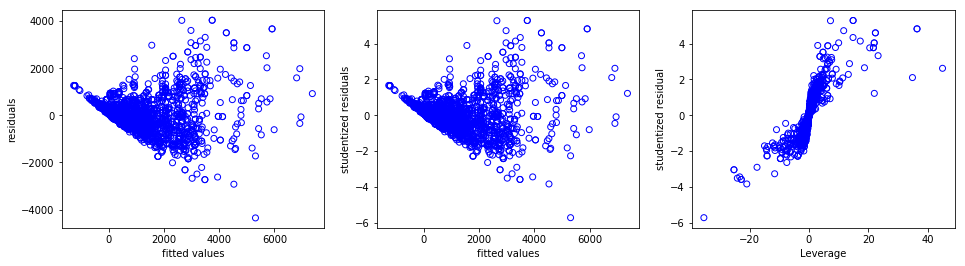

In [6]:
fitted_values = estimate.fittedvalues
residuals = estimate.resid.values
studentized_residuals = OLSInfluence(estimate).resid_studentized_internal
leverages = OLSInfluence(estimate).influence

# Plot
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))

# Residuals
ax1.scatter(fitted_values, residuals, facecolors='none', edgecolors='b');
ax1.set_xlabel('fitted values');
ax1.set_ylabel('residuals');
# Studentized Residuals
ax2.scatter(fitted_values, studentized_residuals, facecolors='none', edgecolors='b');
ax2.set_xlabel('fitted values');
ax2.set_ylabel('studentized residuals');
# Leverages
ax3.scatter(leverages, studentized_residuals, facecolors='none', edgecolors='b');
ax3.set_xlabel('Leverage');
ax3.set_ylabel('studentized residual');

Comments
- There is a problem with heteroscedacity, as the variance of the residuals seems to increase with larger predicted responses leading to a funnel shape in the fitted values-residuals-plot
- The studentized residuals show that several data points are outliers
- The leverage plot shows that there are some high-leverage points

### 1.3 Tackling heteroscedacity: Transforming the response variable Y

In [7]:
X2 = sm.add_constant(dataset[['depth','height','width']])
y2 = dataset.price  ** (1/2)
model2 = sm.OLS(y2,X2)
estimate2 = model2.fit()
print(estimate2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     2016.
Date:                Tue, 14 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:32:21   Log-Likelihood:                -6766.7
No. Observations:                1899   AIC:                         1.354e+04
Df Residuals:                    1895   BIC:                         1.356e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9033      0.562     -6.948      0.0

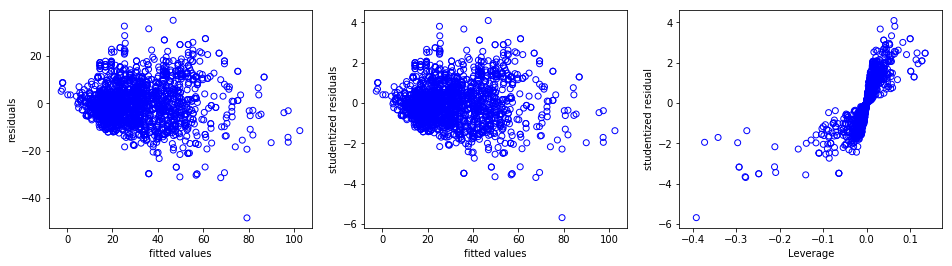

In [8]:
fitted_values2 = estimate2.fittedvalues
residuals2 = estimate2.resid.values
studentized_residuals2 = OLSInfluence(estimate2).resid_studentized_internal
leverages2 = OLSInfluence(estimate2).influence

# Plot
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))

# Residuals
ax1.scatter(fitted_values2, residuals2, facecolors='none', edgecolors='b');
ax1.set_xlabel('fitted values');
ax1.set_ylabel('residuals');
# Studentized Residuals
ax2.scatter(fitted_values2, studentized_residuals2, facecolors='none', edgecolors='b');
ax2.set_xlabel('fitted values');
ax2.set_ylabel('studentized residuals');
# Leverages
ax3.scatter(leverages2, studentized_residuals2, facecolors='none', edgecolors='b');
ax3.set_xlabel('Leverage');
ax3.set_ylabel('studentized residual');

Comments
- By transforming the response variable to $\sqrt{Y}$ it seems we have gotten rid of the heteroscedacity, as the residual plot shows
- Both $R^2$ and $R_{adj}^2$ increased significantly
- There are still a few outliers and high-leverage points in the data

### 1.4 Removing high-leverage points

High-leverage points very strongly influence our linear regression model in a way, that is not adequate in respect to the other points. We therefore will cut off the most extreme values with the help of the leverage statistic for every point. We compare that to the formula $(p+1)/n$ to assess whether a point may be a high-leverage point or not.

In [9]:
indices3 = [i for i,v in enumerate(leverages2) if v < -50*(3+1)/1899 or v > 50*(4/1899)] # Find indices of high-leverage points
X3 = sm.add_constant(dataset[['depth','height','width']].loc[np.setdiff1d(range(0,len(dataset)),indices3)]) # Use the dataset like before but without the high-leverage points
y3 = dataset.price[np.setdiff1d(range(0,len(dataset)),indices3)]  ** (1/2)
model3 = sm.OLS(y3,X3)
estimate3 = model3.fit()
print(estimate3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     2122.
Date:                Tue, 14 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:32:22   Log-Likelihood:                -6542.6
No. Observations:                1867   AIC:                         1.309e+04
Df Residuals:                    1863   BIC:                         1.312e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.1503      0.552     -9.330      0.0

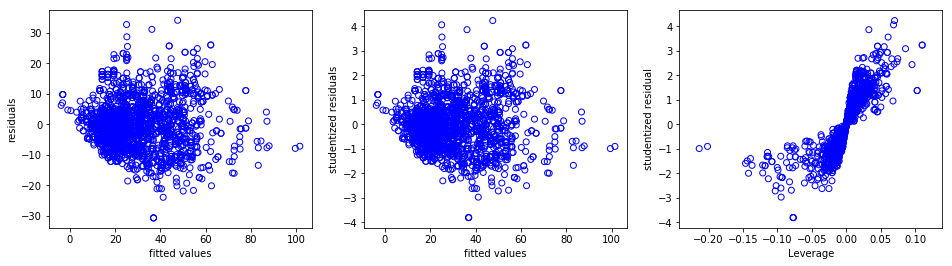

In [10]:
fitted_values3 = estimate3.fittedvalues
residuals3 = estimate3.resid.values
studentized_residuals3 = OLSInfluence(estimate3).resid_studentized_internal
leverages3 = OLSInfluence(estimate3).influence

# Plot
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))

# Residuals
ax1.scatter(fitted_values3, residuals3, facecolors='none', edgecolors='b');
ax1.set_xlabel('fitted values');
ax1.set_ylabel('residuals');
# Studentized Residuals
ax2.scatter(fitted_values3, studentized_residuals3, facecolors='none', edgecolors='b');
ax2.set_xlabel('fitted values');
ax2.set_ylabel('studentized residuals');
# Leverages
ax3.scatter(leverages3, studentized_residuals3, facecolors='none', edgecolors='b');
ax3.set_xlabel('Leverage');
ax3.set_ylabel('studentized residual');

Comments
- We removed high leverage points with a cutoff value of $\pm50*((p+1)/n)$ 
- Without this extension of the "acceptable leverage range" we would've cut off way too many data points
- This inhomogeneity of datapoints indicates that there is some clusting in the data that our current model doesn't capture
- $R^2$ increased slightly
- There are less high-leverage points and outliers then before

## 2. Add more (qualitative) predictors to the model

To better represent the apparent underlying clustering of our datapoints we introduce dummy variables for the column 'category' to our model.

In [11]:
# Create a set of dummy variables for the categoricals
dummies = pd.get_dummies(dataset[['category']])
dataset_wD = pd.concat([dataset[['price','depth','height','width']], dummies], axis=1)

### 2.1 Subset selection: Perform Forward stepwise selection

With 20 possible predictors (3 quantitive and 17 dummy variables), Best subset selection would be too computational expensive. Instead we use Forward stepwise selection. Note that we still use the transformed $\sqrt Y$ response variable

In [12]:
def forward_step_select(df, predictors, response, max_features):
    """
    Regresses response onto predictors using a forward step algorithm. Features are added based on minimum RSS.
    
    PARAMETERS
    -----------
    df : dataframe containing predictors and responses
    predictors : list of all possible model predictors
    response : list[variable] to regress onto predictors in df
    max_features : maximum number of features to use from predictors list
    
    RETURNS
    --------
    list of models with increasing number of features upto max_features
    
    """
    
    def process_linear_model(features):
        """
        Constructs Linear Model Regression of response onto features.
        """
        # Create design Matrix
        X = sm.add_constant(df[features])
        y = df[response] ** (1/2)

        model = sm.OLS(y,X).fit()
        RSS = model.ssr
        return (model, RSS)

    def update_model(best_features, remaining_features):
        """
        Computes the RSS of possible new models and returns the model with the lowest RSS.
        """
        results = []
        
        for feature in remaining_features:
            results.append(process_linear_model(best_features + [feature]))
            
        # select model with the lowest RSS
        new_model = sorted(results, key= itemgetter(1)).pop(0)[0]
        new_features = list(new_model.params.index)[1:]
        
        return new_features, new_model
    
    # Create list to hold models, model features and the remaining features to test
    models = []
    best_features = []
    remaining_features = predictors
    
    while remaining_features and len(best_features) < max_features:
        
        # get the best new feature set from update_model
        new_features, new_model = update_model(best_features, remaining_features)
        # update the best features to include the one we just found
        best_features = new_features  
        # reduce the available features for the next round
        remaining_features =  [feature for feature in predictors if feature not in best_features]
        
        # append the new_features and model so we can compare models with different features later
        models.append((new_features,new_model))
        
    return models

In [13]:
# Call our forward step function
# set up inputs
predictors = list(dataset_wD.columns)
predictors.remove('price')
# call forward_step_select
models = forward_step_select(dataset_wD,predictors,['price'],max_features=20)

### 2.1.1 Estimating the test error: Using $AIC, BIC, R_{adj}^2$

First, after having found the "best" models with up to 20 predictors by forward subset selection, we try to estimate the test error by adjusting the training error for the model size. We use AIC, BIC and Adjusted $R^2$.

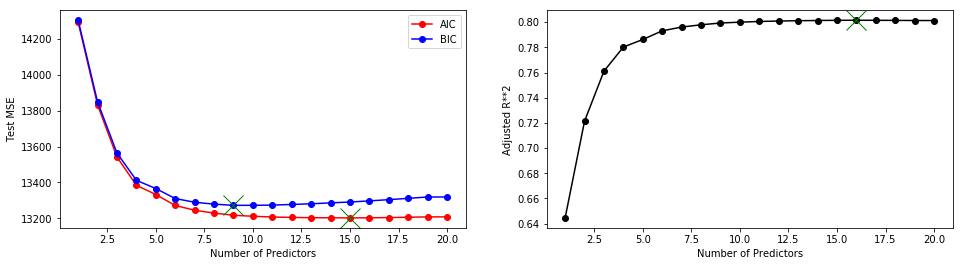

In [14]:
# Now that we have the best models for a given number of variables we can compare models with different
# predictors using aic, bic and r_adj. Note AIC and Mallow's Cp are proportional to each other. We will 
# create plots of these statistics to find the best model for the price of IKEA furniture.
aics = [models[x][1].aic for x in range(len(models))]
bics = [models[x][1].bic for x in range(len(models))]
r_adj = [models[x][1].rsquared_adj for x in range(len(models))]

# find the mins/maxes
min_aic_index, min_aic = min(enumerate(aics), key=itemgetter(1))
min_bic_index, min_bic = min(enumerate(bics), key=itemgetter(1))
max_radj_index, max_radj = max(enumerate(r_adj), key=itemgetter(1))

num_predictors = np.linspace(1,len(models),len(models))
# Create a plot
fig,(ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
# Add test MSE estimates
ax1.plot(num_predictors, aics, 'r', marker='o', label='AIC');
ax1.plot(num_predictors, bics, 'b', marker='o', label='BIC')

# add the minimums to the axis
ax1.plot(min_aic_index+1, min_aic, 'gx', markersize=20, markeredgewidth=1)
ax1.plot(min_bic_index+1, min_bic, 'gx', markersize=20, markeredgewidth=1)

# Labels and Legend
ax1.set_xlabel('Number of Predictors');
ax1.set_ylabel('Test MSE');
ax1.legend(loc='best');

# Add Adj R**2
ax2.plot(num_predictors, r_adj,'k', marker='o')
ax2.plot(max_radj_index+1, max_radj, 'gx', markersize=20, markeredgewidth=1)
ax2.set_xlabel('Number of Predictors');
ax2.set_ylabel('Adjusted R**2');

Comments:
- BIC indicates that a model with 9 predictors would lead to the lowest test error
- AIC and Adjusted $R^2$ indicate that the models with 15 resp. 16 predictors would have the lowest test error
- Further investigation is needed

### 2.1.2 Estimating the test error: Validation Model Selection

In [15]:
# create an index to break the dataframe with Dummies into a train and test set that are roughly equal in size
np.random.seed(3) # Change this value if you want to try different splits of data in the test and training set
index = np.random.choice([True, False], size=len(dataset_wD))

# split the data into train and validation sets
dataset_wD_train = dataset_wD[index]
dataset_wD_test = dataset_wD[~index]

In [16]:
# Now we construct models from the training set selecting the best models using our best_subsets function
predictors = list(dataset_wD_train.columns)
predictors.remove('price')
models = forward_step_select(dataset_wD_train, predictors, ['price'], max_features=20)

In [17]:
# now for each of the models we will perform prediction and get MSE on the test data
mses = np.array([])
for model in models:
    # get the predictors for this model, ignore constant
    features = list(model[1].params.index[1:])
    
    # get the corresponding columns of df_test
    X_test = sm.add_constant(dataset_wD_test[features])
    
    # make prediction for this model
    salary_pred = model[1].predict(X_test)
    
    # get the MSE for this model
    mses = np.append(mses, np.mean((salary_pred - dataset_wD_test.price.values)**2))
min_index, min_mse = min(enumerate(mses), key=itemgetter(1))

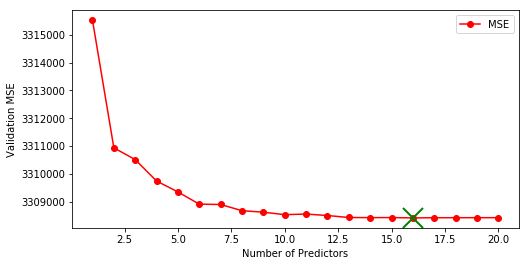

In [18]:
# We can also plot all the models MSEs
# set predictors for x-axis
num_predictors = np.linspace(1,len(models),len(models))

fig, ax1 = plt.subplots(figsize=(8,4));

# add the mse and mimimum mse to the plot
ax1.plot(num_predictors, mses, 'r', marker='o', label='MSE')
ax1.plot(min_index+1, min_mse, 'gx', markersize=20, markeredgewidth=2)

# Labels and Legend
ax1.set_xlabel('Number of Predictors');
ax1.set_ylabel('Validation MSE');
ax1.legend(loc='best');

Comments:
- While there are different results, depending on the split of the original dataset into the training and test sets, the lowest test MSE lies usually in the realm of 8+ predictors, after which it usually stays relatively constant
- Because of this and because of the fact, that also AIC and $R_{adj}^2$ stay don't change much at this number of predictors, we assume the minimum of the BIC, 9 predictors, as our optimum.

In [19]:
# Now we construct models from the full dataset (no splitting in test and training set) selecting the best models using our forward_step_select function
predictors = list(dataset_wD.columns)
predictors.remove('price')
models = forward_step_select(dataset_wD, predictors, ['price'], max_features=9)

# Print out the Coeffecients of the 9 predictor model determined as Best by Validation approach above.
print(models[8][1].params)

const                                       -2.221052
width                                        0.126599
depth                                        0.145708
height                                       0.077884
category_Bookcases & shelving units         -5.817664
category_Beds                                9.784097
category_Sofas & armchairs                   6.304086
category_TV & media furniture               -3.635282
category_Cabinets & cupboards                3.069295
category_Chests of drawers & drawer units    2.936141
dtype: float64


### 2.2 Creating an optimized model
Based on the results of the previous chapter [2.1](#2.1-Subset-selection:-Perform-Forward-stepwise-selection), we now construct our optimized model.

In [20]:
X4 = sm.add_constant(dataset_wD[['depth','height','width','category_Bookcases & shelving units','category_Beds','category_Sofas & armchairs','category_TV & media furniture','category_Cabinets & cupboards','category_Chests of drawers & drawer units']])
y4 = dataset.price  ** (1/2)
model4 = sm.OLS(y4,X4)
estimate4 = model4.fit()
print(estimate4.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     840.8
Date:                Tue, 14 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:32:30   Log-Likelihood:                -6598.2
No. Observations:                1899   AIC:                         1.322e+04
Df Residuals:                    1889   BIC:                         1.327e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

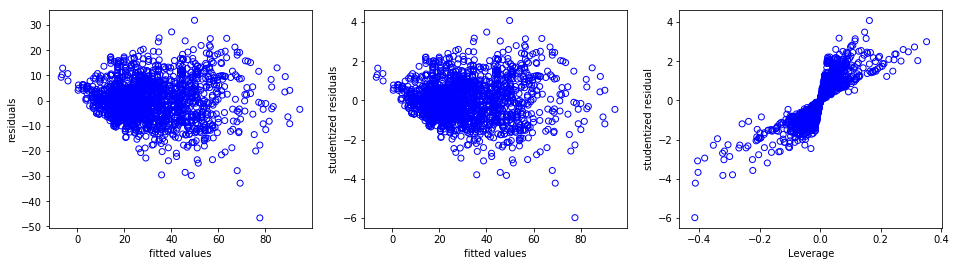

In [21]:
fitted_values4 = estimate4.fittedvalues
residuals4 = estimate4.resid.values
studentized_residuals4 = OLSInfluence(estimate4).resid_studentized_internal
leverages4 = OLSInfluence(estimate4).influence

# Plot
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))

# Residuals
ax1.scatter(fitted_values4, residuals4, facecolors='none', edgecolors='b');
ax1.set_xlabel('fitted values');
ax1.set_ylabel('residuals');
# Studentized Residuals
ax2.scatter(fitted_values4, studentized_residuals4, facecolors='none', edgecolors='b');
ax2.set_xlabel('fitted values');
ax2.set_ylabel('studentized residuals');
# Leverages
ax3.scatter(leverages4, studentized_residuals4, facecolors='none', edgecolors='b');
ax3.set_xlabel('Leverage');
ax3.set_ylabel('studentized residual');

Comments:  
It's noticeable that the high-leverages now seem to be much more symetrically distributed (to both sides of 0), compared to the model with only the quantitative predictors. There seems to be a category of furniture which is quite unusually represented by just the quantitative predictors in comparison with the other types of furniture. When we introduce the dummy variables those items seem to fit in better with the rest of the dataset. We will take a deeper look into that theory later.

### 2.2.1 Revisiting VIFs for our new model

In [22]:
VIFs = [(predictor, variance_inflation_factor(X4.values,_)) \
        for _,predictor in enumerate(list(X4))] # list(X) returns column names of df

print('Variance Inflation Factors')
for tup in VIFs:
    print('{:20}'.format(tup[0]), '{:.3f}'.format(tup[1]))

Variance Inflation Factors
const                11.379
depth                2.147
height               1.413
width                1.772
category_Bookcases & shelving units 1.337
category_Beds        1.227
category_Sofas & armchairs 1.956
category_TV & media furniture 1.190
category_Cabinets & cupboards 1.186
category_Chests of drawers & drawer units 1.105


Still, there seems to be no problem with multicolinearity in the data

### 2.2.2 Removing high-leverage points from the data

In [23]:
indices5 = [i for i,v in enumerate(leverages4) if v < -40*((9+1)/1899) or v > 40*((9+1)/1899)] # Find indices of high-leverage points
dataset_wD_nHL = dataset_wD.loc[np.setdiff1d(range(0,len(dataset_wD)),indices5)] # construct new dataframe that doesnt contain the High leverage points
X5 = sm.add_constant(dataset_wD_nHL[['depth','height','width','category_Bookcases & shelving units','category_Beds','category_Sofas & armchairs','category_TV & media furniture','category_Cabinets & cupboards','category_Chests of drawers & drawer units']]) # Use the dataset like before but without the high-leverage points
y5 = dataset_wD_nHL.price ** (1/2)
model5 = sm.OLS(y5,X5)
estimate5 = model5.fit()
print(estimate5.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     930.0
Date:                Tue, 14 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:32:31   Log-Likelihood:                -6347.2
No. Observations:                1864   AIC:                         1.271e+04
Df Residuals:                    1854   BIC:                         1.277e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

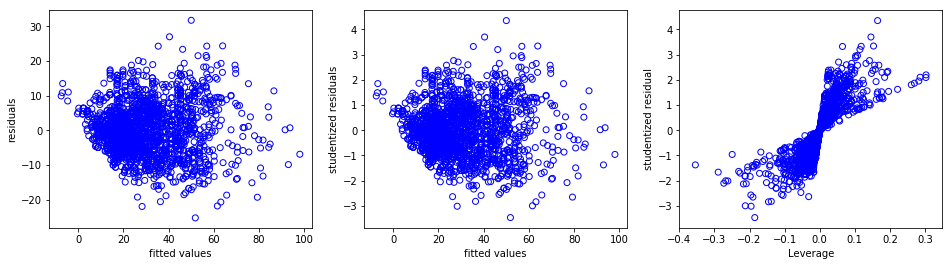

In [24]:
fitted_values5 = estimate5.fittedvalues
residuals5 = estimate5.resid.values
studentized_residuals5 = OLSInfluence(estimate5).resid_studentized_internal
leverages5 = OLSInfluence(estimate5).influence

# Plot
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))

# Residuals
ax1.scatter(fitted_values5, residuals5, facecolors='none', edgecolors='b');
ax1.set_xlabel('fitted values');
ax1.set_ylabel('residuals');
# Studentized Residuals
ax2.scatter(fitted_values5, studentized_residuals5, facecolors='none', edgecolors='b');
ax2.set_xlabel('fitted values');
ax2.set_ylabel('studentized residuals');
# Leverages
ax3.scatter(leverages5, studentized_residuals5, facecolors='none', edgecolors='b');
ax3.set_xlabel('Leverage');
ax3.set_ylabel('studentized residual');

Comments:
- By carefully removing around 30 of the most extreme high-leverage points we get a much better model for the rest of the dataset

### 2.2.3 Further examination of unusual data points

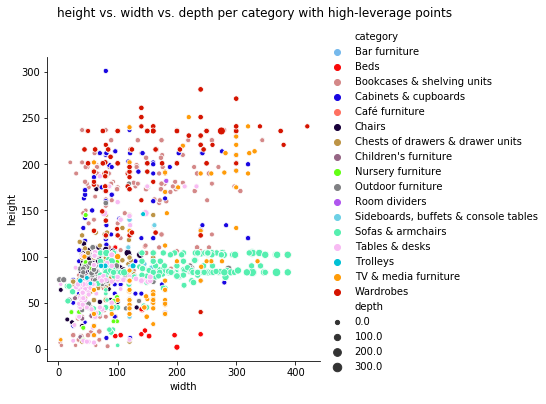

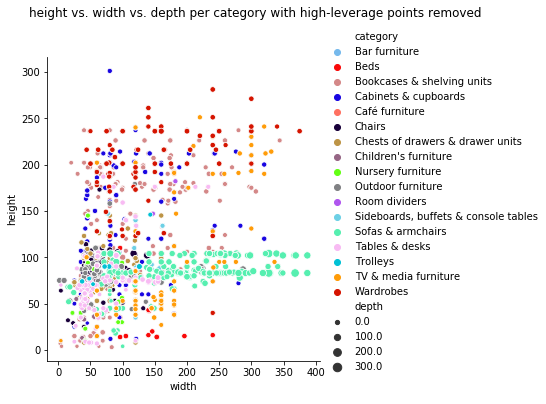

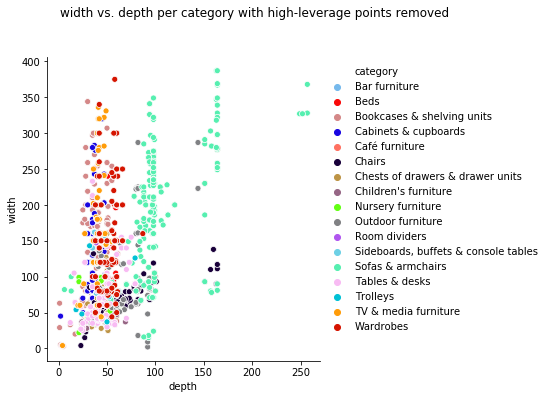

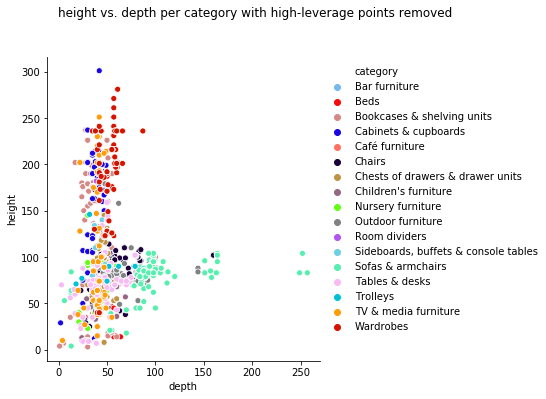

In [25]:
# set custom color palette
colors = ["#76b9ec","#f90909","#d48888","#1906e1","#ff7161","#19003a","#bd9446","#966685","#63ff14","#808184","#b056ef","#6dd0e5","#56efb0","#f8bbf3","#00c1d5","#ff9c09","#d51400"]
sns.set_palette(sns.color_palette(colors))
a = sns.relplot(x='width', y='height', size='depth', hue='category', data=dataset);
a.fig.suptitle("height vs. width vs. depth per category with high-leverage points", y= 1.1)
b= sns.relplot(x='width', y='height', size='depth', hue='category', data=dataset.loc[np.setdiff1d(range(0,len(dataset)),indices5)]);
b.fig.suptitle("height vs. width vs. depth per category with high-leverage points removed", y=1.1)
b1= sns.relplot(x='depth', y='width', hue='category', data=dataset.loc[np.setdiff1d(range(0,len(dataset)),indices5)]);
b1.fig.suptitle("width vs. depth per category with high-leverage points removed", y=1.1)
b2= sns.relplot(x='depth', y='height', hue='category', data=dataset.loc[np.setdiff1d(range(0,len(dataset)),indices5)]);
b2.fig.suptitle("height vs. depth per category with high-leverage points removed", y=1.1)
plt.show()

Comments:
- Those plots support our theory from chapter [2.2](#2.2-Creating-an-optimized-model):
- While the values of height and width are quite evenly distributed among the categories, a large depth seems to usually appear in the Sofas & armchairs category

## 2.3 Adding interaction terms

By looking at the distribution of predictors over categories in chapter [2.2.3](#2.2.3-Further-examination-of-unusual-data-points) and introducing some interaction variables we can increase the accuracy of our model a little further.

In [26]:
dataset_wD_nHL['int_Sofas_depth'] = dataset_wD_nHL['category_Sofas & armchairs'] * dataset_wD_nHL.depth
dataset_wD_nHL['int_Sofas_width'] = dataset_wD_nHL['category_Sofas & armchairs'] * dataset_wD_nHL.width
dataset_wD_nHL['int_Bookcases_height_width'] = dataset_wD_nHL['category_Bookcases & shelving units'] * dataset_wD_nHL.height * dataset_wD_nHL.width
X6 = sm.add_constant(dataset_wD_nHL[['int_Bookcases_height_width','int_Sofas_depth','int_Sofas_width','depth','height','width','category_Beds','category_Sofas & armchairs','category_Cabinets & cupboards','category_TV & media furniture','category_Chests of drawers & drawer units','category_Bookcases & shelving units']]) # Use the dataset like before but without the high-leverage points
y6 = dataset_wD_nHL.price ** (1/2)
model6 = sm.OLS(y6,X6)
estimate6 = model6.fit()
print(estimate6.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     734.9
Date:                Tue, 14 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:32:37   Log-Likelihood:                -6305.9
No. Observations:                1864   AIC:                         1.264e+04
Df Residuals:                    1851   BIC:                         1.271e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Comments:
- To further increase the accuracy of our model we introduced 3 interaction variables: "Bookcases * width * height", "Sofas * depth" and "Sofas * width"
- Bookcases & shelving units seem to be cheaper then the rest of furniture items when made higher and wider, which is the reason why the corresponding value of the interaction variable is negative
- Sofas tend to be the only objects in the dataset that have some really large depth value. With a higher depth their price however isn't influenced as much as it is with the other furniture items.
- The width of a Sofa however seems to be more influential on the resulting price then it is for other furniture items, which makes sense because a wider sofa usually means the change from eg. a 2-seater to a 3-seater. Apparently this increase in practicality makes people pay more for that sofa then for a sofa that has simply more depth or height. 

## 3. Use of a General Additive Model (GAM)

Our findings from chapter [2.2.3](#2.2.3-Further-examination-of-unusual-data-points) indicate that the use of a GAM might lead to even better results. We use natural cubic splines of degree 4 to get a better estimate for our quantitative variables.

In [27]:
# Build Patsy Design Matrix #
#############################
# Build one large design matrix constructed from natural splines for year (referred to here as f1) (dof=4) and 
# age (referred to here as f2) (dof=5) and add education categorical. NOTE constraints='center' is the default of
# R's GAM library. It forces the smooth functions f1(year), f2(age) to have zero mean. 
design = dmatrix("cr(height, df=4, constraints='center') + cr(width, df=4, constraints='center') + cr(depth, df=4, constraints='center') + category",
                 data={"height":dataset.height, "width":dataset.width, "depth":dataset.depth, "category":dataset.category}, return_type="dataframe")

# Fit Statsmodels OLS #
########################
# Again a GAM is just one large linear regression onto splines basis funcs so just construct an OLS model.
gam = sm.OLS(endog=dataset.price**(1/2), exog=design).fit()

In [28]:
print(gam.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     285.6
Date:                Tue, 14 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:32:37   Log-Likelihood:                -6548.1
No. Observations:                1899   AIC:                         1.315e+04
Df Residuals:                    1870   BIC:                         1.332e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

Comments:
- The GAM slightly leads to slightly better prediction at the cost of complexity, readibility and interpretability
- We don't feel like the benefit is large enough to outweigh the disadvantages, and therefore conclude that the model from chapter [2.3](#2.3-Adding-interaction-terms) is the best overall model we found in this project
- The real underlying correlation between the price and height/ width/ depth doesn't seem to divergate that much from the linear assumption, that it would pay off to remove the linear assumption from our model

# 4. Conclusions & Outlook

- The best model we've found is described in chapter [2.3](#2.3-Adding-interaction-terms)
- There is a strong linear relationship between the size of an item and the squareroot of its price
- This relationship can be modeled even better by introducing dummy variables for some categories and interaction terms between those categories and the quantitative variables
- The dataset has some interesting properties that we found: e.g. most items with a high depth are sofas or armchairs and the linear relationship between size and price seems to weaker for bookcases and shelving units
- Some of those properties can be modeled by interaction terms
- We don't feel like its worth to give up the linear assumption because the real underlying correlation doesn't seem to divergate too much from it


- It could be worth to spend more time looking into other interaction parameters because they seem to be a good way of further increasing the accuracy of our model without overfitting the model to just this particular dataset
- When introducing more interaction variables, subset selection should be repeated to find the best available model
- With more computational power, best subset selection instead of forward subset selection could be a valid strategy, to avoid running into a local minimum